In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import streamlit as st
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler  # (if needed)

In [4]:
data = pd.read_csv("Pancreatic_Dataset.csv")


In [5]:
data


,sample_id,patient_cohort,sampleBPTBorigin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S592,Cohort3,BPTB,24,F,1,NaN,NaN,9.0,0.45623,0.959656,2.980000,21.789000,NaN
4,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
598,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
599,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
600,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


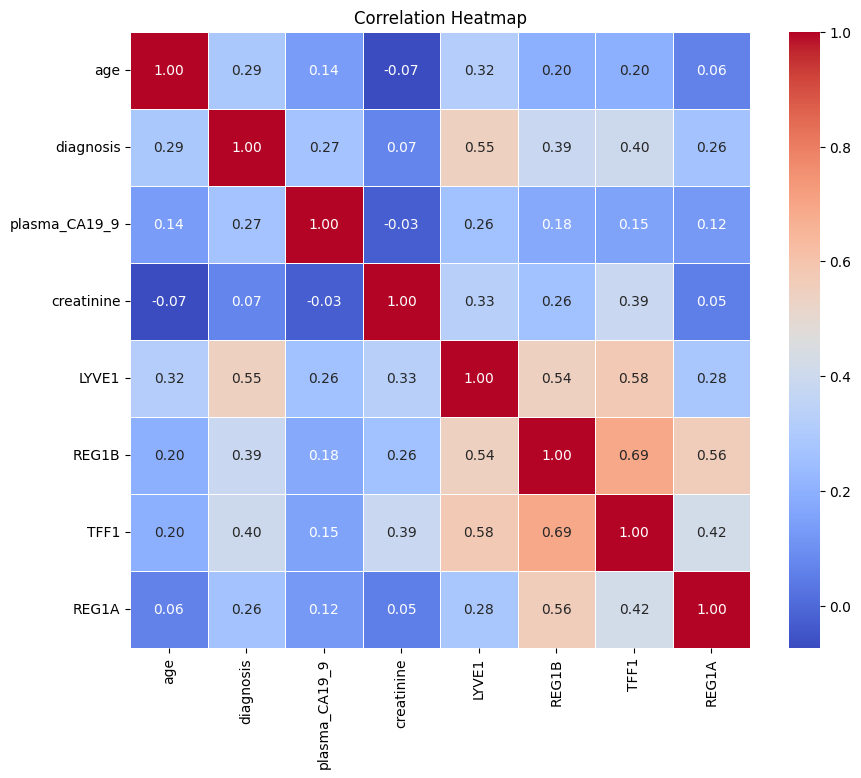

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

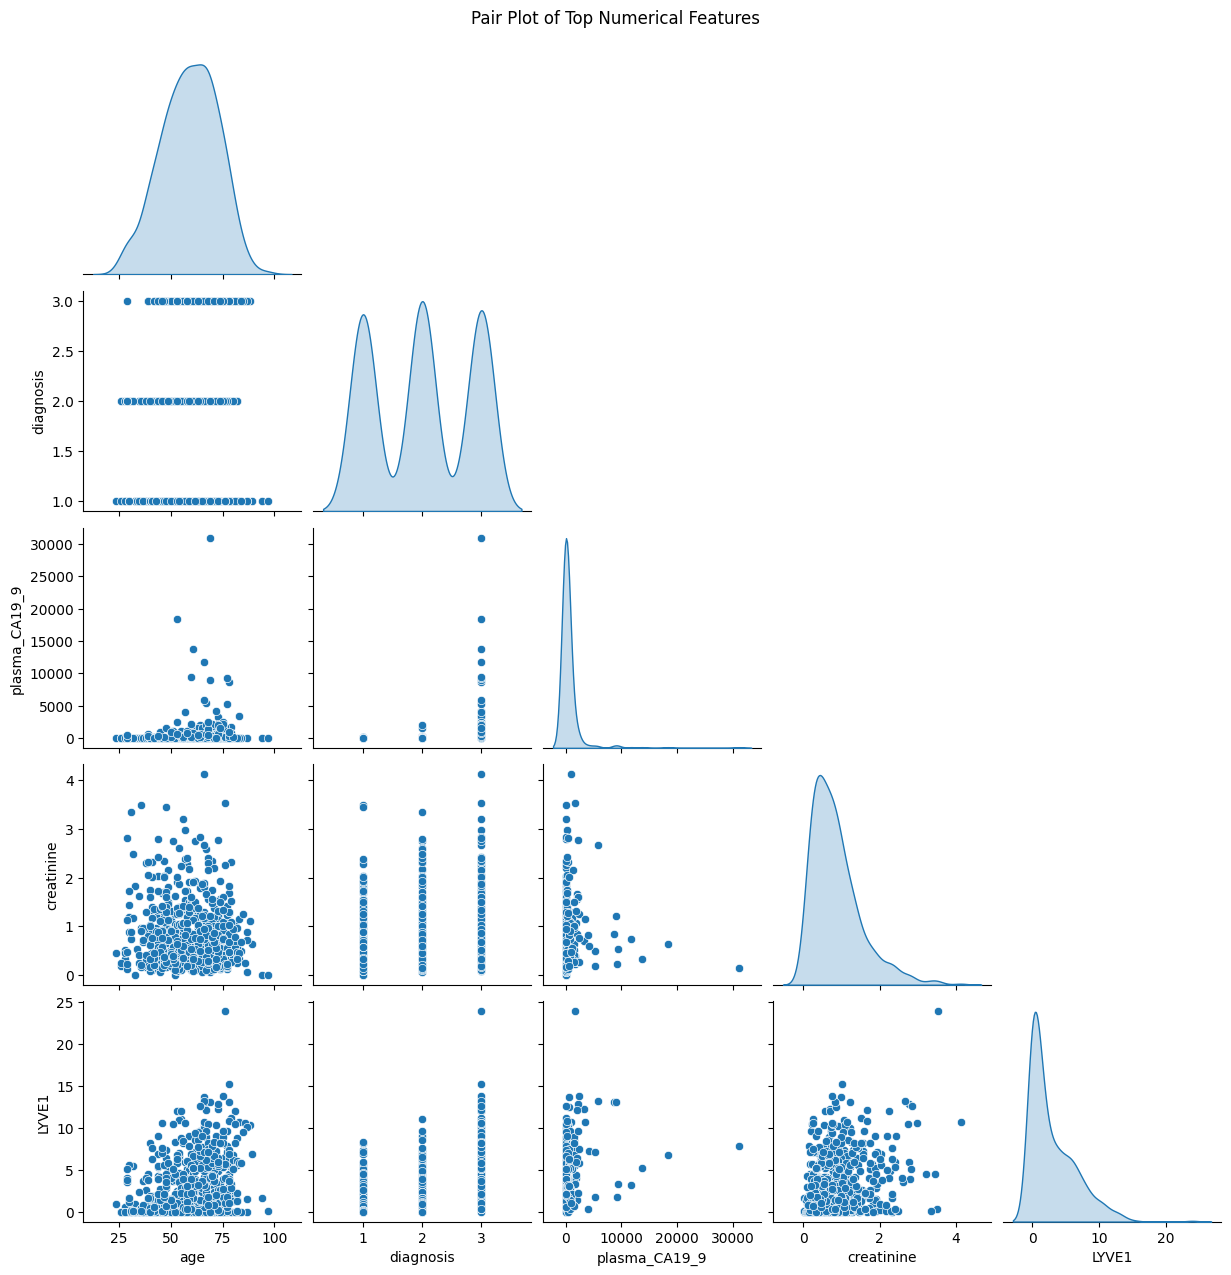

In [7]:
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
if len(numerical_columns) > 5:
    numerical_columns = numerical_columns[:5]  # Use only the first 5 numerical columns for pairplot
sns.pairplot(data[numerical_columns], diag_kind="kde", corner=True)
plt.suptitle("Pair Plot of Top Numerical Features", y=1.02)
plt.show()

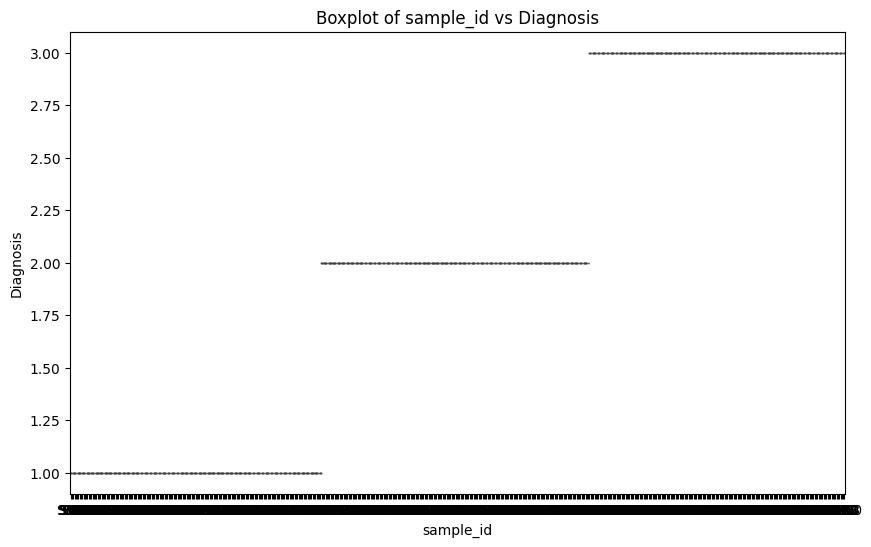

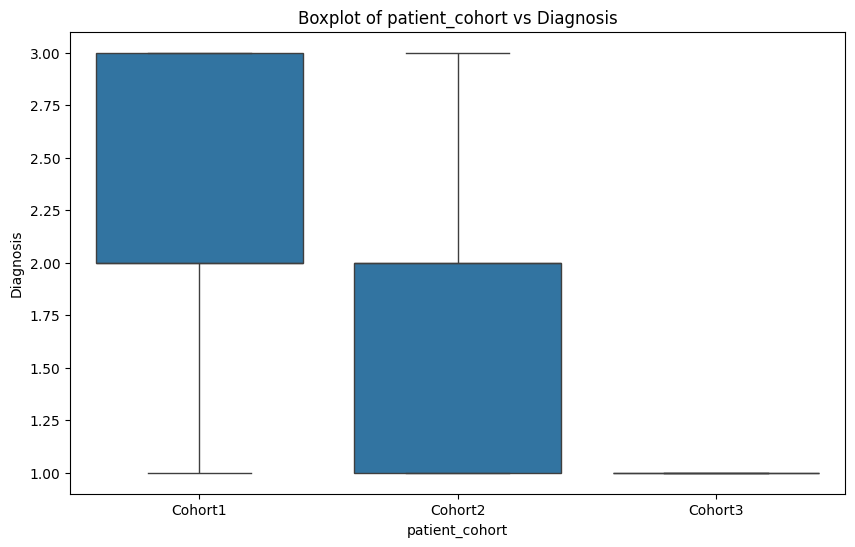

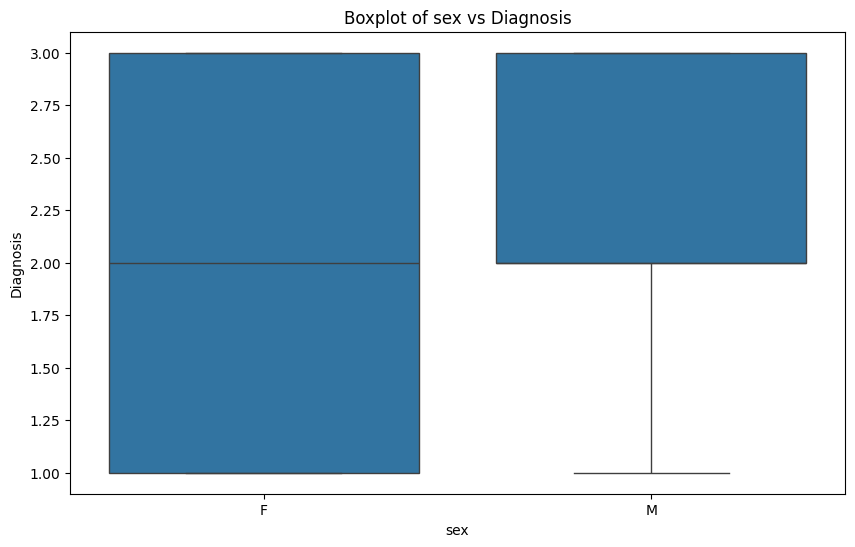

In [8]:
# Boxplots for Categorical vs Numerical Analysis
categorical_columns = ["sample_id", "patient_cohort", "sample_origin", "sex"]
for cat_col in categorical_columns:
    if cat_col in data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=data[cat_col], y=data["diagnosis"], data=data)
        plt.title(f"Boxplot of {cat_col} vs Diagnosis")
        plt.xlabel(cat_col)
        plt.ylabel("Diagnosis")
        plt.show()

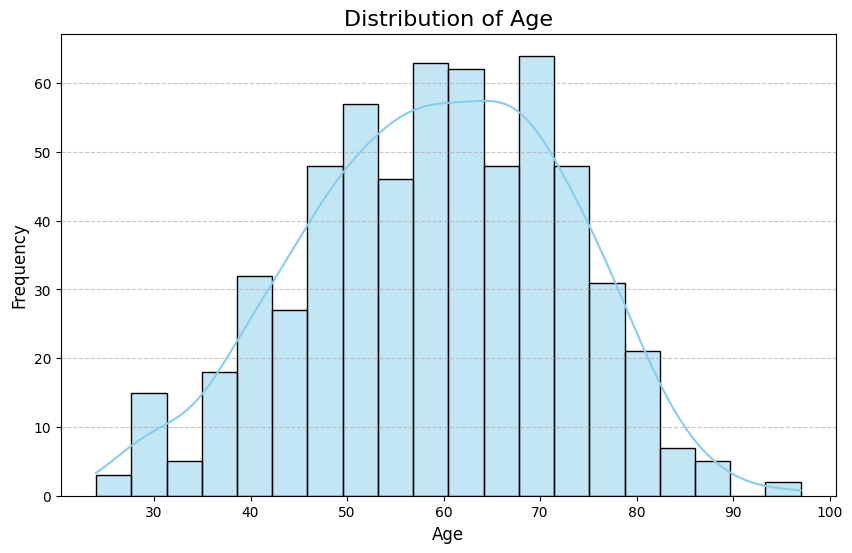

In [9]:
if "age" in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x="age", bins=20, kde=True, color="skyblue")
    plt.title("Distribution of Age", fontsize=16)
    plt.xlabel("Age", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print("The 'age' column is not present in the dataset.")

In [10]:
print(data.dtypes)

sample_id                   object
patient_cohort              object
sampleBPTBorigin            object
age                          int64
sex                         object
diagnosis                    int64
stage                       object
benign_sample_diagnosis     object
plasma_CA19_9              float64
creatinine                 float64
LYVE1                      float64
REG1B                      float64
TFF1                       float64
REG1A                      float64
dtype: object


In [11]:
## Pre Processing

In [12]:
data = data.drop(columns=["sample_id", "patient_cohort"])  # Assuming these are identifiers, not features

In [19]:
# Ensure column names are stripped of extra spaces
data.columns = data.columns.str.strip()

# Define the correct column names for conversion
categorical_columns = ["sampleBPTBorigin", "sex", "stage", "benign_sample_diagnosis"]

# Convert only existing columns to categorical
for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].astype("category")
    else:
        print(f"Warning: Column '{col}' not found in data")

In [20]:
# === Handle Missing Values ===
# Fill missing numeric values with the median
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

In [21]:
# Fill missing categorical values with "Unknown"
for col in categorical_columns:
    data[col] = data[col].cat.add_categories("Unknown").fillna("Unknown")

In [22]:
# === Encode Categorical Columns ===
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [23]:

# === Separate Features and Target Variable ===
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

In [24]:
noise = np.random.normal(0, 1, X.shape)  # Mean = 0, Std dev = 1
X_noisy = X + noise  # Add noise to original dataset



In [25]:
# Scale the noisy dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) + np.random.normal(0, 0.5, X.shape)


In [26]:
# === Split Data into Training and Testing Sets ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "SVM": SVC(C=0.5, kernel="linear"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
}

In [28]:
model_results = {}

for model_name, model in models.items():
    print(f"=== Evaluating Model: {model_name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    model_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
    }
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\n")


    

=== Evaluating Model: Logistic Regression ===
Model: Logistic Regression
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1-Score: 0.86


=== Evaluating Model: Random Forest ===
Model: Random Forest
Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1-Score: 0.85


=== Evaluating Model: Decision Tree ===
Model: Decision Tree
Accuracy: 0.80
Precision: 0.82
Recall: 0.80
F1-Score: 0.80


=== Evaluating Model: SVM ===
Model: SVM
Accuracy: 0.84
Precision: 0.85
Recall: 0.84
F1-Score: 0.84


=== Evaluating Model: K-Nearest Neighbors ===
Model: K-Nearest Neighbors
Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1-Score: 0.84


=== Evaluating Model: Naive Bayes ===
Model: Naive Bayes
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1-Score: 0.83


=== Evaluating Model: Gradient Boosting ===
Model: Gradient Boosting
Accuracy: 0.84
Precision: 0.85
Recall: 0.84
F1-Score: 0.84




In [29]:
# Load dataset
data = pd.read_csv("Pancreatic_Dataset.csv")

# Assuming the last column is the target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose the best model
best_model_name = "Random Forest"  # Change as per your selection

# Dictionary of models
model_mapping = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Get a fresh instance of the best model
best_model = model_mapping.get(best_model_name, None)
if best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10]
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
elif best_model_name == "SVM":
    param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"]
    }
elif best_model_name == "K-Nearest Neighbors":
    param_grid = {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    }
else:
    print("GridSearchCV not implemented for this model.")
    param_grid = None


In [31]:
print("NaN values in y_train:", y_train.isna().sum())


NaN values in y_train: 230


In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert to Pandas Series
y_train_series = pd.Series(y_train, dtype=str)
y_test_series = pd.Series(y_test, dtype=str)

# Fit LabelEncoder on combined Series
y_le = LabelEncoder()
y_le.fit(pd.concat([y_train_series, y_test_series]))  # Fit on all labels

# Transform labels
y_train = y_le.transform(y_train_series)
y_test = y_le.transform(y_test_series)

In [36]:
# Ensure column names are stripped of extra spaces
data.columns = data.columns.str.strip()

# Define the correct column names for conversion
categorical_columns = ["sampleBPTBorigin", "sex", "stage", "benign_sample_diagnosis"]

# Convert only existing columns to categorical
for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].astype("category")
    else:
        print(f"Warning: Column '{col}' not found in data")

In [37]:
import pickle
if best_model_name:
    with open("best_model.pkl", "wb") as model_file:
        pickle.dump(best_model, model_file)
    print(f"Best Model ({best_model_name}) saved as 'best_model.pkl'.")

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)
print("Scaler saved as 'scaler.pkl'.")

with open("labelencoder.pkl", "wb") as label_encoder:
    pickle.dump(le, label_encoder)
print("Scaler saved as 'labelencoder.pkl'.")



Best Model (Random Forest) saved as 'best_model.pkl'.
Scaler saved as 'scaler.pkl'.
Scaler saved as 'labelencoder.pkl'.
